In [212]:
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
figsize(14, 7)

# hustle stat - average mph, miles run, balls deflected, contested shots, stats per minute (steals, o rebounds, feet), 
# jump balls, Loose balls recovered, boxouts, screen assists, charges, team, average salary, all nba or all star teams 
# https://stats.nba.com/players/speed-distance/?sort=AVG_SPEED&dir=1

# To do:
# 1) change the way calculate hustle score 
#        a) per minute 
#        b) add in distance and speed (https://stats.nba.com/players/speed-distance/?sort=DIST_MILES_DEF&dir=1&Season=2017-18&SeasonType=Regular%20Season)
#        c) standardize or not needed?
# 2) change up scatter plots 
# 3) multiple webdrivers at once? possible? good idea?
# 4) sort by position
# 5) trends over time - playoff teams, non-playoff teams, championship teams
# 6) predict current season outcomes

# GP >= 40 make sure not for current season



In [213]:
def getHustleStats(year):
    return getYearStats("https://stats.nba.com/players/hustle/?sort=MIN&dir=-1&Season=" + year + "&SeasonType=Regular%20Season", year)

def getRegularStats(year):
    return getYearStats("https://stats.nba.com/leaders/?Season=" + year + "&SeasonType=Regular%20Season", year)

def getYearStats(url, year):
    # Use an automated browser so that the webpage is rendered properly
    browser = webdriver.Safari()
    browser.get(url)
    
    # Edit HTML so that we can get the whole table
    browser.execute_script('document.getElementsByClassName("stats-table-pagination__select")[0].setAttribute("id", "btn")')
    browser.execute_script('document.getElementById("btn").children[0].setAttribute("id", "select-all")')
    nextButton = browser.find_element_by_id('btn')
    allButton = browser.find_element_by_id('select-all')
    
    # Click on buttons to get whole table
    nextButton.click()
    allButton.click()
    
    # Get HTML and parse
    innerHTML = browser.execute_script("return document.body.innerHTML")
    root = BeautifulSoup(innerHTML, "lxml")
    table = pd.read_html(str(root.find("table")))
    table = table[0]
    
    # Add year column for later table merging
    table['year'] = year
    browser.close()
    return table

def getPositions(year):
    url = "https://www.basketball-reference.com/leagues/NBA_" + str(year) + "_per_game.html"
    r = requests.get(url)
    root = BeautifulSoup(r.content, "lxml")
    data = root.find("table")
    positions_table = pd.read_html(str(data))[0]
    positions_table['year'] = str(year - 1) + "-" + str(year - 2000)
    return positions_table

def stripChars(series):
    return series.str.replace('.', '').str.replace('Jr', '').str.replace(',', '').str.replace('III', '').str.replace('II', '').str.replace('IV', '').str.rstrip()

In [214]:
hustle16_17 = getHustleStats("2016-17")
hustle17_18 = getHustleStats("2017-18")
regular16_17 = getRegularStats("2016-17")
regular17_18 = getRegularStats("2017-18")

In [215]:
hustleStats = hustle16_17.append(hustle17_18)
hustleStats['Player'] = stripChars(hustleStats['Player'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17


In [216]:
regularStats = regular16_17.append(regular17_18)
regularStats.head()

,#,Player,GP,MIN,PTS,FGM,FGA,FG%,3PM,3PA,...,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,EFF,year
0,1,Russell Westbrook,81,34.6,31.6,10.2,24.0,42.5,2.5,7.2,...,84.5,1.7,9.0,10.7,10.4,1.6,0.4,5.4,33.8,2016-17
1,2,James Harden,81,36.4,29.1,8.3,18.9,44.0,3.2,9.3,...,84.7,1.2,7.0,8.1,11.2,1.5,0.5,5.7,32.4,2016-17
2,3,Isaiah Thomas,76,33.8,28.9,9.0,19.4,46.3,3.2,8.5,...,90.9,0.6,2.1,2.7,5.9,0.9,0.2,2.8,24.7,2016-17
3,4,Anthony Davis,75,36.1,28.0,10.3,20.3,50.5,0.5,1.8,...,80.2,2.3,9.5,11.8,2.1,1.3,2.2,2.4,31.1,2016-17
4,5,DeMar DeRozan,74,35.4,27.3,9.7,20.9,46.7,0.4,1.7,...,84.2,0.9,4.3,5.2,3.9,1.1,0.2,2.4,22.7,2016-17


In [217]:
positions16_17 = getPositions(2017)[['Player', 'Pos', 'year']]
positions17_18 = getPositions(2018)[['Player', 'Pos', 'year']]

In [218]:
positions = positions16_17.append(positions17_18)
positions['Player'] = stripChars(positions['Player'])

In [219]:
hustleStatsTemp = pd.merge(hustleStats, positions, on=['Player', 'year'], how='left')
hustleStatsTemp[pd.isnull(hustleStatsTemp['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
158,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
244,Taurean Prince,ATL,23,59,16.6,0.1,0.2,1.4,0.0,0.0,0.6,0.0,0.0,0.05,2.9,2.4,5.2,2016-17,NaN
275,Nene,HOU,34,67,17.9,2.8,6.5,1.5,0.0,0.0,0.7,0.0,0.0,0.15,4.9,1.7,6.6,2016-17,NaN
601,Vincent Hunter,MEM,23,4,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.5,1.0,2017-18,NaN
669,Walter Lemon,NOP,25,5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.4,0.2,1.6,2017-18,NaN
745,Juancho Hernangomez,DEN,22,25,11.1,0.2,0.4,0.5,0.2,0.2,0.3,50.0,50.0,0.04,2.3,1.5,3.8,2017-18,NaN
840,Nene,HOU,35,52,14.6,2.0,4.9,1.4,0.1,0.3,0.5,25.0,75.0,0.04,3.5,1.9,5.4,2017-18,NaN
882,Wes Iwundu,ORL,23,62,16.5,0.1,0.2,0.8,0.1,0.3,0.5,30.0,70.0,0.05,1.8,1.7,3.5,2017-18,NaN
1162,Taurean Prince,ATL,24,82,30.0,0.2,0.5,1.8,0.5,0.6,1.1,43.3,56.7,0.11,3.8,2.8,6.6,2017-18,NaN


In [220]:
positions.loc[positions['Player'] == 'Nene Hilario', 'Player'] = 'Nene'
positions.loc[positions['Player'] == 'Taurean Waller-Prince', 'Player'] = 'Taurean Prince'
hustleStats = pd.merge(hustleStats, positions, on=['Player', 'year'], how='left')
hustleStats[pd.isnull(hustleStats['Pos'])]

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
158,Juancho Hernangomez,DEN,21,62,13.6,0.3,0.7,0.7,0.0,0.0,0.5,0.0,0.0,0.00,3.1,1.7,4.7,2016-17,NaN
601,Vincent Hunter,MEM,23,4,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.5,1.0,2017-18,NaN
669,Walter Lemon,NOP,25,5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.4,0.2,1.6,2017-18,NaN
745,Juancho Hernangomez,DEN,22,25,11.1,0.2,0.4,0.5,0.2,0.2,0.3,50.0,50.0,0.04,2.3,1.5,3.8,2017-18,NaN
882,Wes Iwundu,ORL,23,62,16.5,0.1,0.2,0.8,0.1,0.3,0.5,30.0,70.0,0.05,1.8,1.7,3.5,2017-18,NaN


In [221]:
hustleStats = hustleStats.dropna(subset=['Pos'])
hustleStats.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,ScreenAssists PTS,Deflections,OFF Loose BallsRecovered,DEF Loose BallsRecovered,Loose BallsRecovered,% Loose BallsRecovered OFF,% Loose BallsRecovered DEF,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,Pos
0,Danuel House,WAS,24,1,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,SG
1,John Lucas,MIN,34,5,2.1,0.0,0.0,0.8,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,2016-17,PG
2,Larry Sanders,CLE,28,5,2.5,0.2,0.4,0.2,0.0,0.0,0.2,0.0,0.0,0.0,1.4,0.0,1.4,2016-17,C
3,Steve Novak,MIL,34,8,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.1,0.5,2016-17,PF
4,Brice Johnson,LAC,23,3,3.1,0.3,1.0,0.7,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.3,1.7,2016-17,PF


Cleaning the table: First, we delete any players who do not average 15 minutes per game.  Then we drop columns that we will not be using. 

In [222]:
table = table[table['MIN'] >= 15] # Delete players who did not average 15 minutes per game 
table = table[table['GP'] >= 40] # Delete players who did not play 40 games 
# Drop unused columns 
table = table.drop(['ScreenAssists PTS', 'OFF Loose BallsRecovered', 'DEF Loose BallsRecovered', '% Loose BallsRecovered OFF', '% Loose BallsRecovered DEF'], axis=1)
# table = table.drop(['Contested2PT Shots', 'Contested3PT Shots'], axis=1) # not sure why this isn't working 
table.head()

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year
157,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17
158,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17
161,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17
163,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17
164,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17


In order to calculate our hustle score, we will use the sum of screen assists, deflections, loose balls recovered, charges drawn, and contested shots.  However, if we just took the sum of those statistics for each player, certain statistics, such as contested shots, would effect the overall hustle score more than others because its numbers are generally higher.  Therefore, we decided to normalize each statistic by dividing its value by the max for that specific statistic.  

In [223]:
maxScreenAssists = (table['ScreenAssists']/table['MIN']).max()
maxDeflections = (table['Deflections']/table['MIN']).max()
maxLooseBallsRecovered = (table['Loose BallsRecovered']/table['MIN']).max()
maxChargesDrawn = (table['ChargesDrawn']/table['MIN']).max()
maxContestedShots = (table['ContestedShots']/table['MIN']).max()
print("maxScreenAssists per minute: " + str(maxScreenAssists))
print("maxDeflections per minute: " + str(maxDeflections))
print("maxLooseBallsRecovered per minute: " + str(maxLooseBallsRecovered))
print("maxChargesDrawn per minute: " + str(maxChargesDrawn))
print("maxContestedShots per minute: " + str(maxContestedShots))

# avgScreenAssists = table['ScreenAssists'].mean()
# stdScreenAssists = table['ScreenAssists'].std()
# avgDeflections = table['Deflections'].mean()
# stdDeflections = table['Deflections'].std()
# avgLooseBallsRecovered = table['Loose BallsRecovered'].mean()
# stdLooseBallsRecovered = table['Loose BallsRecovered'].std()
# avgChargesDrawn = table['ChargesDrawn'].mean()
# stdChargesDrawn = table['ChargesDrawn'].std()
# avgContestedShots = table['ContestedShots'].mean()
# stdContestedShots = table['ContestedShots'].std()

maxScreenAssists per minute: 0.21223021582733814
maxDeflections per minute: 0.13291139240506328
maxLooseBallsRecovered per minute: 0.06046511627906977
maxChargesDrawn per minute: 0.026114649681528664
maxContestedShots per minute: 0.5750000000000001


In [224]:
# table['HustleScore'] = table['ScreenAssists']/maxScreenAssists + table['Deflections']/maxDeflections + table['Loose BallsRecovered']/maxLooseBallsRecovered + table['ChargesDrawn']/maxChargesDrawn + table['ContestedShots']/maxContestedShots
table['HustleScore'] = (table['ScreenAssists']/maxScreenAssists + table['Deflections']/maxDeflections + table['Loose BallsRecovered']/maxLooseBallsRecovered + table['ChargesDrawn']/maxChargesDrawn + table['ContestedShots']/maxContestedShots)/(table['MIN'])
table.head()
# win_perc_salary_table['standardized_payroll'] = (win_perc_salary_table['payroll'] - win_perc_salary_table['avg_payroll'])/win_perc_salary_table['std_payroll']

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,HustleScore
157,Alan Williams,PHX,24,47,15.1,2.1,1.0,0.6,0.00,5.7,0.9,6.6,2016-17,2.570865
158,Patrick McCaw,GSW,21,71,15.1,0.2,1.1,0.5,0.00,2.3,1.3,3.5,2016-17,1.561242
161,Semaj Christon,OKC,24,64,15.2,0.1,1.0,0.4,0.00,1.8,1.1,2.8,2016-17,1.281575
163,Alec Burks,UTA,25,42,15.5,0.1,0.8,0.4,0.00,1.6,1.4,3.0,2016-17,1.182130
164,Alex Abrines,OKC,23,68,15.5,0.2,0.9,0.3,0.01,2.2,1.4,3.6,2016-17,1.246396


In [225]:
# Sort table by HustleScore
table = table.sort_values(by=['HustleScore'],ascending=False)
table['year'] = '2017-2018'
table.head(30)

,Player,TEAM,AGE,GP,MIN,ScreenAssists,Deflections,Loose BallsRecovered,ChargesDrawn,Contested2PT Shots,Contested3PT Shots,ContestedShots,year,HustleScore
266,Nerlens Noel,DAL,23,51,20.5,2.2,2.7,0.9,0.04,7.0,1.5,8.5,2017-2018,3.018503
223,Zaza Pachulia,GSW,33,70,18.1,3.5,1.8,0.8,0.00,5.5,0.8,6.3,2017-2018,2.995673
220,Nene,HOU,34,67,17.9,2.8,1.5,0.7,0.15,4.9,1.7,6.6,2017-2018,2.976426
236,Gorgui Dieng,MIN,28,79,16.9,1.7,1.3,0.8,0.18,4.9,1.8,6.7,2017-2018,2.932944
243,Lucas Nogueira,TOR,24,57,19.1,3.7,1.6,0.5,0.00,8.3,1.9,10.2,2017-2018,2.904731
374,Cody Zeller,CHA,24,62,27.8,5.9,2.0,1.1,0.03,7.9,1.2,9.1,2017-2018,2.806288
433,Draymond Green,GSW,27,76,32.5,2.3,3.9,1.2,0.17,9.6,4.1,13.7,2017-2018,2.780374
260,Jakob Poeltl,TOR,22,82,18.6,2.8,1.0,0.7,0.05,8.5,1.5,9.9,2017-2018,2.764838
529,DeMarcus Cousins,NOP,27,48,36.2,2.3,2.7,1.6,0.50,10.7,2.7,13.3,2017-2018,2.759389
206,Amir Johnson,PHI,31,74,15.8,2.5,1.0,0.7,0.08,4.7,0.8,5.5,2017-2018,2.753736


Text(0, 0.5, 'Hustle Scores')

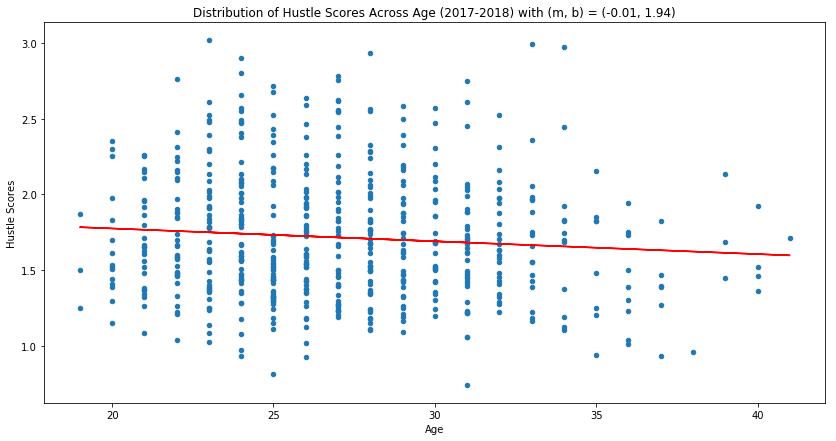

In [226]:
scatter = table.plot.scatter('AGE', 'HustleScore')

(m, b) = np.polyfit(table['AGE'], table['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in table['AGE']]
scatter.plot(table['AGE'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Age (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Age")
scatter.set_ylabel("Hustle Scores")

Text(0, 0.5, 'Hustle Scores')

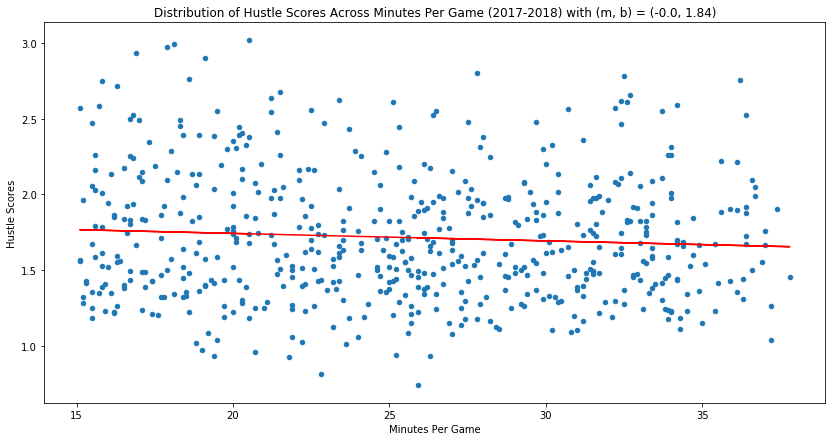

In [227]:
scatter = table.plot.scatter('MIN', 'HustleScore')

(m, b) = np.polyfit(table['MIN'], table['HustleScore'], 1)
# Calculate the actual best fit line 
regression_line = [(m*x)+b for x in table['MIN']]
scatter.plot(table['MIN'], regression_line, color='red') 

# Label the plot
scatter.set_title("Distribution of Hustle Scores Across Minutes Per Game (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
scatter.set_xlabel("Minutes Per Game")
scatter.set_ylabel("Hustle Scores")

In [228]:
teamHustleTable = pd.DataFrame(table.groupby('TEAM')['HustleScore'].sum())
teamHustleTable = teamHustleTable.sort_values(by=['HustleScore'],ascending=False)
teamHustleTable = teamHustleTable.reset_index()
teamHustleTable.head()

,TEAM,HustleScore
0,TOR,40.167973
1,ATL,38.391969
2,PHI,37.620539
3,CHI,36.895617
4,CLE,35.946348


In [229]:
teamWinsTable = pd.read_csv('teams_2017_2018.csv')
teamWinsTable.columns = ['0', 'TEAM', 'Wins', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
teamWinsTable.head(8)

,0,TEAM,Wins,2,3,4,5,6,7,8,9,10,11,12
0,Official NBA Conference Overall Standings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Eastern Conference,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Team,W,L,Win%,GB,Conf,Div,Home,Road,OT,Last 10,Streak,NaN
5,1,TOR,59,23,0.72,0,40-12,12-4,34-7,25-16,4-2,6-4,L 1,NaN
6,2,BOS,55,27,0.671,4,33-19,12-4,27-14,28-13,2-2,6-4,W 1,NaN
7,3,PHI,52,30,0.634,7,34-18,9-7,30-11,22-19,1-1,10-0,W 16,NaN


In [230]:
teamWinsTable = teamWinsTable.drop(teamWinsTable.index[0]).drop(teamWinsTable.index[1]).drop(teamWinsTable.index[2]).drop(teamWinsTable.index[3]).drop(teamWinsTable.index[4])
teamWinsTable = teamWinsTable.drop(['0', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], axis=1)
teamWinsTable.head(8)

,TEAM,Wins
5,TOR,59
6,BOS,55
7,PHI,52
8,CLE,50
9,IND,48
10,MIA,44
11,MIL,44
12,WAS,43


In [231]:
teamTable = pd.merge(teamHustleTable, teamWinsTable, on=['TEAM'])
teamTable.head()

,TEAM,HustleScore,Wins
0,TOR,40.167973,59
1,ATL,38.391969,24
2,PHI,37.620539,52
3,CHI,36.895617,27
4,CLE,35.946348,50


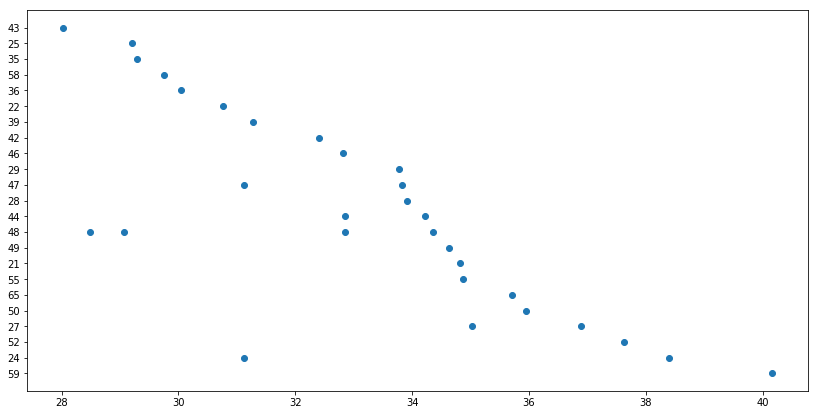

In [232]:
#plt.scatter(x=teamTable['HustleScore'], y=teamTable['Wins'])
x = teamTable['HustleScore']
y = teamTable['Wins']
fig, ax = plt.subplots()
ax.scatter(x, y) # try to switch x and y here

# (m, b) = np.polyfit(teamTable['HustleScore'], teamTable['Wins'], 1)
# # Calculate the actual best fit line 
# regression_line = [(m*x)+b for x in teamTable['HustleScore']]
# scatter.plot(teamTable['HustleScore'], regression_line, color='red') 

# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018) with (m, b) = (" + str(round(m,2)) + ", " + str(round(b, 2)) + ")")
# ax.set_xlabel("Team Hustle Score")
# ax.set_ylabel("Team Wins")

# scatter = teamTable.plot.scatter('Wins', 'HustleScore')
# # Label the plot
# scatter.set_title("Distribution of Hustle Scores Across Team Wins (2017-2018)")
# scatter.set_xlabel("Team Wins")
# scatter.set_ylabel("Team Hustle Score")